### 1. Get System Info

In [1]:
import cupy as cp
import numpy as np
import torch

np.set_printoptions(threshold=np.inf)  # Show all elements

# Get the default device ID (usually 0)
device_id = cp.cuda.runtime.getDevice()

# Get device properties
props = cp.cuda.runtime.getDeviceProperties(device_id)

# Print device name
device_name = props['name'].decode('utf-8')
print(f"Device Name: {device_name}")

# Print compute capability
cc_major = props['major']
cc_minor = props['minor']
print(f"Compute Capability: {cc_major}.{cc_minor}")

# Print total memory
total_mem = props['totalGlobalMem'] / (1024 ** 3)  # Convert bytes to GB
print(f"Total Memory: {total_mem:.2f} GB")

Device Name: Tesla V100-PCIE-16GB
Compute Capability: 7.0
Total Memory: 15.77 GB


### 2. Load Dataset

In [2]:
import tensorflow as tf
import cupy as cp
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

#flatten the dataset
x_train_flat = x_train.reshape(x_train.shape[0], 28 * 28).T
x_test_flat = x_test.reshape(x_test.shape[0], 28 * 28).T

train_size = int(0.8 * x_train_flat.shape[1])  # 48000

x_val = x_train_flat[:, train_size:]     # Last 12000 columns for validation
x_train_flat = x_train_flat[:, :train_size]   # First 48000 columns for training

print("X_train Shape: ", x_train_flat.shape)
print("X_Val Shape: ", x_val.shape)
print("X_test Shape: ", x_test_flat.shape)

y_train = cp.eye(10)[y_train].T #convert to one hot encoded vectors

y_val = y_train[:, train_size:]
y_train = y_train[:, :train_size]

print("Y_Train Shape: ", y_train.shape)
print("Y_Val Shape: ", y_val.shape)

y_test = cp.eye(10)[y_test].T #convert to one hot encoded vectors

print("Y_Test Shape: ", y_test.shape)

epochs = 10
batch_size = 64

2025-06-08 13:03:17.442123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-08 13:03:17.632794: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 13:03:19.083631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-06-08 13:03:19.083715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

X_train Shape:  (784, 48000)
X_Val Shape:  (784, 12000)
X_test Shape:  (784, 10000)
Y_Train Shape:  (10, 48000)
Y_Val Shape:  (10, 12000)
Y_Test Shape:  (10, 10000)


### 3. dpn_0. The object oriented approach with sequential forward and backprop

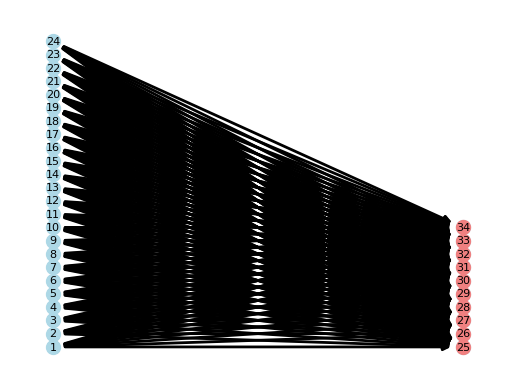

In [3]:
from dpn_0.dpn import DPN as DPN_0
import cupy as cp

model_0 = DPN_0()
cp.random.seed(42)

input_features = 784 # for MNIST dataset
hidden_nodes = 24
output_nodes = 10

#manually create the network structure
for i in range(hidden_nodes):
    model_0.create_node('Relu', input_features, 'input')

inputs = model_0.input_nodes.copy()
for i in range(output_nodes):
    new_node = model_0.create_node('None', input_features, 'input')
    model_0.output_nodes.append(new_node)
    model_0.vertices[new_node].output_size = 1

    for node in inputs:
        model_0.add_connection(node, new_node)

model_0.compile()
model_0.visualize()

Extract weights before training

In [4]:
#extract weights from DPN

DPN_weights = []
biases = []
for i, node in enumerate(model_0.input_nodes):
    DPN_weights.append(model_0.vertices[node].weights.copy())
    biases.append(model_0.vertices[node].bias)

max_pad = DPN_weights[-1].shape[1]

for i in range(len(DPN_weights)):
    row = cp.pad(DPN_weights[i],  pad_width=((0, 0), (1, max_pad - DPN_weights[i].shape[1])), mode='constant', constant_values=(biases[i], 0))
    DPN_weights[i] = row

DPN_weights = cp.vstack(DPN_weights)

Run Model

In [5]:
train_metrics_0, val_metrics_0, test_metrics_0 = model_0.execute(epochs, batch_size, x_train_flat, y_train, x_val, y_val, x_test_flat, y_test)

Epoch: 1 Total_Time: 55.9089 Average_Time_per_batch: 0.0745 Train_Accuracy: 0.8750 Train_Loss: 0.4271 Val_Accuracy: 0.9213 Val_Loss: 0.4036
Epoch: 2 Total_Time: 55.7995 Average_Time_per_batch: 0.0744 Train_Accuracy: 0.9062 Train_Loss: 0.3628 Val_Accuracy: 0.9352 Val_Loss: 0.3154
Epoch: 3 Total_Time: 55.7645 Average_Time_per_batch: 0.0744 Train_Accuracy: 0.9062 Train_Loss: 0.2821 Val_Accuracy: 0.9423 Val_Loss: 0.2717
Epoch: 4 Total_Time: 55.8121 Average_Time_per_batch: 0.0744 Train_Accuracy: 0.9219 Train_Loss: 0.2309 Val_Accuracy: 0.9473 Val_Loss: 0.2561
Epoch: 5 Total_Time: 55.7709 Average_Time_per_batch: 0.0744 Train_Accuracy: 0.9219 Train_Loss: 0.1891 Val_Accuracy: 0.9513 Val_Loss: 0.2423
Epoch: 6 Total_Time: 55.8072 Average_Time_per_batch: 0.0744 Train_Accuracy: 0.9219 Train_Loss: 0.1528 Val_Accuracy: 0.9544 Val_Loss: 0.2383
Epoch: 7 Total_Time: 55.7513 Average_Time_per_batch: 0.0743 Train_Accuracy: 0.9688 Train_Loss: 0.1277 Val_Accuracy: 0.9558 Val_Loss: 0.2247
Epoch: 8 Total_Time:

### 4. dpn_1. The block based forward appproach with sequential backprop in cupy

Use dpn_0 weights

In [6]:
DPN_1_weights = DPN_weights.copy()

In [7]:
from dpn_1.dpn import DPN as DPN_1

model_1 = DPN_1(input_features, hidden_nodes + output_nodes, output_nodes)
model_1.set_weights(DPN_1_weights)
model_1.compile()

In [8]:
#append 1s to multiply with biases
ones_column_train = cp.ones((1, x_train_flat.shape[1]))
x_train_flat_with_ones = cp.vstack((ones_column_train, x_train_flat))

ones_column_val = cp.ones((1, x_val.shape[1]))
x_val_with_ones = cp.vstack((ones_column_val, x_val))

ones_column_test = cp.ones((1, x_test_flat.shape[1]))
x_test_flat_with_ones = cp.vstack((ones_column_test, x_test_flat))

alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
t = 1  # Timestep

In [9]:
train_metrics_1, val_metrics_1 = model_1.fit(x_train_flat_with_ones, y_train, x_val_with_ones, y_val, epochs, batch_size, alpha, beta_1, beta_2, epsilon)
test_metrics_1 = model_1.test(x_test_flat_with_ones, y_test)

Epoch: 1 Total_Time: 1.4742 Average_Time_per_batch: 0.0020 Train_Accuracy: 0.8750 Train_Loss: 0.4271 Val_Accuracy: 0.9213 Val_Loss: 0.2867
Epoch: 2 Total_Time: 1.4612 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.9062 Train_Loss: 0.3628 Val_Accuracy: 0.9352 Val_Loss: 0.2394
Epoch: 3 Total_Time: 1.4610 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.9062 Train_Loss: 0.2821 Val_Accuracy: 0.9423 Val_Loss: 0.2091
Epoch: 4 Total_Time: 1.4595 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.9219 Train_Loss: 0.2309 Val_Accuracy: 0.9473 Val_Loss: 0.1890
Epoch: 5 Total_Time: 1.4621 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.9219 Train_Loss: 0.1891 Val_Accuracy: 0.9513 Val_Loss: 0.1752
Epoch: 6 Total_Time: 1.4610 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.9219 Train_Loss: 0.1528 Val_Accuracy: 0.9544 Val_Loss: 0.1644
Epoch: 7 Total_Time: 1.4602 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.9688 Train_Loss: 0.1277 Val_Accuracy: 0.9558 Val_Loss: 0.1570
Epoch: 8 Total_Time: 1.4598

### 5. dpn_2. Block based forward and backprop approach in pytorch

In [10]:
def cp_to_torch_tensor(cp_array):
    return torch.tensor(cp.asnumpy(cp_array)).float().cuda()

In [11]:
from torch.utils.data import TensorDataset, DataLoader

X_train = cp_to_torch_tensor(x_train_flat).T  # [N, 784]
X_val = cp_to_torch_tensor(x_val).T
X_test = cp_to_torch_tensor(x_test_flat).T

Y_train = cp_to_torch_tensor(y_train).T  # [N]
Y_val = cp_to_torch_tensor(y_val).T
Y_test = cp_to_torch_tensor(y_test).T

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size)

In [12]:
from dpn_2.dpn import DPN as DPN_2
    
model_2 = DPN_2(input_features, hidden_nodes + output_nodes, output_nodes).cuda()

In [13]:
import torch.nn as nn

DPN_2_weights = []

limits = DPN_weights.shape[1] - cp.argmax(DPN_weights[:, ::-1] != 0, axis=1)
start = 1
old_limit = 0

for limit in limits:
    if limit > old_limit:
        old_limit = limit
        DPN_2_weights.append(nn.Parameter(torch.as_tensor(DPN_weights[limit - 1 - input_features:, start:limit].copy().get()).float().cuda()))
        start = limit

DPN_2_biases = nn.Parameter(torch.as_tensor(DPN_weights[:, 0].get()).float().cuda())

In [14]:
model_2.weights.extend(DPN_2_weights)
model_2.biases = DPN_2_biases

In [15]:
import torch.optim as optim

model_2 = torch.jit.trace(model_2, torch.randn(batch_size, input_features).cuda())
optimizer = optim.Adam(model_2.parameters(), lr=alpha, betas=(beta_1, beta_2), eps=epsilon)
criterion = nn.CrossEntropyLoss()

/ediss_data/ediss4/sarosh/personal/pathnn/spn/dpn_2/dpn.py:22: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_start_idx < nodes - output_size:


In [16]:
from utils import train

train_metrics_2, val_metrics_2, test_metrics_2 = train(model_2, train_loader, val_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 1.8248 Average_Time_per_batch: 0.0024 Train_Accuracy: 0.8702 Train_Loss: 0.4785 Validation_Accuracy: 0.9195 Validation_Loss: 0.2815
Epoch: 2 Total_Time: 1.7477 Average_Time_per_batch: 0.0023 Train_Accuracy: 0.9241 Train_Loss: 0.2684 Validation_Accuracy: 0.9345 Validation_Loss: 0.2319
Epoch: 3 Total_Time: 1.7408 Average_Time_per_batch: 0.0023 Train_Accuracy: 0.9354 Train_Loss: 0.2225 Validation_Accuracy: 0.9441 Validation_Loss: 0.2031
Epoch: 4 Total_Time: 1.7688 Average_Time_per_batch: 0.0024 Train_Accuracy: 0.9456 Train_Loss: 0.1906 Validation_Accuracy: 0.9476 Validation_Loss: 0.1851
Epoch: 5 Total_Time: 1.7532 Average_Time_per_batch: 0.0023 Train_Accuracy: 0.9526 Train_Loss: 0.1651 Validation_Accuracy: 0.9514 Validation_Loss: 0.1653
Epoch: 6 Total_Time: 1.7495 Average_Time_per_batch: 0.0023 Train_Accuracy: 0.9573 Train_Loss: 0.1463 Validation_Accuracy: 0.9555 Validation_Loss: 0.1534
Epoch: 7 Total_Time: 1.7361 Average_Time_per_batch: 0.0023 Train_Accuracy: 0.9613

In [17]:
from dpn_3.dpn import DPN as DPN_3
    
model_3 = DPN_3(input_features, hidden_nodes + output_nodes, output_nodes).cuda()

In [18]:
model_3 = torch.jit.trace(model_3, torch.randn(batch_size, input_features).cuda())
optimizer = optim.Adam(model_3.parameters(), lr=alpha, betas=(beta_1, beta_2), eps=epsilon)
criterion = nn.CrossEntropyLoss()

In [19]:
train_metrics_3, val_metrics_3, test_metrics_3 = train(model_3, train_loader, val_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 1.4286 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.8782 Train_Loss: 0.4726 Validation_Accuracy: 0.9235 Validation_Loss: 0.2742
Epoch: 2 Total_Time: 1.1907 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9237 Train_Loss: 0.2655 Validation_Accuracy: 0.9349 Validation_Loss: 0.2311
Epoch: 3 Total_Time: 1.1925 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9361 Train_Loss: 0.2190 Validation_Accuracy: 0.9429 Validation_Loss: 0.2002
Epoch: 4 Total_Time: 1.2277 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9458 Train_Loss: 0.1878 Validation_Accuracy: 0.9505 Validation_Loss: 0.1769
Epoch: 5 Total_Time: 1.2255 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9515 Train_Loss: 0.1645 Validation_Accuracy: 0.9530 Validation_Loss: 0.1645
Epoch: 6 Total_Time: 1.2282 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9565 Train_Loss: 0.1462 Validation_Accuracy: 0.9552 Validation_Loss: 0.1554
Epoch: 7 Total_Time: 1.2317 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9607